In [97]:
from bertopic import BERTopic
import pandas as pd
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
import matplotlib.pyplot as plt
import seaborn as sns
from utils import clean_traffic


In [98]:

def most_visited_topic_cluster(df,topics_count):
    topic_stats = df.groupby('topic')['traffic_numeric'].agg(['mean', 'median'])
    max = {"mean":0,"topic":None}
    r = range(0,topics_count)
    for i in r:
        element = topic_stats['mean'][i]
        comp = max["mean"]
        if element >= comp:
            max['mean'] = element
            max['topic'] = i
    return max

def max_element(List):
    list_max_element = 0
    for e in List:
        if e > list_max_element:
            list_max_element = e
    return list_max_element

In [ ]:
data = pd.read_csv("../preprocssed_data/cleaned_data_USA.csv")    
dataFrame = data[['newsTitle']]
strings_list = [item[0] for item in dataFrame.values.tolist()]


In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(strings_list, show_progress_bar=True)

Batches: 100%|██████████| 94/94 [00:09<00:00,  9.73it/s]


In [4]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [5]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [6]:
vectorizer_model = CountVectorizer(stop_words="english")

In [7]:

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [8]:
topic_model = BERTopic(
# Pipeline models
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
vectorizer_model=vectorizer_model,
representation_model=representation_model,
# Hyperparameters
top_n_words=10,
verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(strings_list)

# Show topics
names = topic_model.get_topic_info().Name
topic_model.get_topic_info()

2024-11-26 19:57:48,935 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 94/94 [00:09<00:00,  9.76it/s]
2024-11-26 19:57:58,599 - BERTopic - Embedding - Completed ✓
2024-11-26 19:57:58,600 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-26 19:58:17,027 - BERTopic - Dimensionality - Completed ✓
2024-11-26 19:58:17,029 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-26 19:58:17,166 - BERTopic - Cluster - Completed ✓
2024-11-26 19:58:17,176 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-26 19:58:25,374 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,968,-1_new_know_watch_says,"[new, know, watch, says, day, star, video, tim...","[2017, premiere, watch, channel, live, instagr...","[watch, star, 2017, birthday, season, jenner, ...","[new, star, video, time, years, people, birthd...",[Watch 2017 Rose Bowl Parade Live Online Start...
1,0,322,0_trump_donald_trumps_obama,"[trump, donald, trumps, obama, inauguration, s...","[donald, trump, ivanka, inauguration, trumps, ...","[trumps, obama, inauguration, snl, sean, secre...","[inauguration, president, secretary, security,...",[Are we really stuck with President Donald Tru...
2,1,213,1_nfl_super_patriots_bowl,"[nfl, super, patriots, bowl, draft, packers, c...","[nfl, falcons, packers, cowboys, seahawks, red...","[nfl, patriots, packers, cowboys, seahawks, ch...","[draft, playoff, loss, playoffs, score, team, ...",[2017 NFL Playoff Odds Atlanta Falcons Vs Gree...
3,2,179,2_nba_warriors_game_lebron,"[nba, warriors, game, lebron, cavaliers, cavs,...","[cavs, nba, lebron, nbas, cavaliers, warriors,...","[nba, warriors, lebron, cavaliers, cavs, trade...","[trade, points, playoffs, win, rest, rumors, t...","[NBA schedule, Draymond flattens LeBron as War..."
4,3,173,3_basketball_ncaa_tournament_bowl,"[basketball, ncaa, tournament, bowl, state, co...","[ncaa, clemson, uconn, louisville, ucla, gonza...","[ncaa, tournament, carolina, duke, gonzaga, us...","[basketball, tournament, bowl, state, college,...",[College Football Playoff Clemson vs Ohio Stat...
5,4,106,4_day_patricks_2017_easter,"[day, patricks, 2017, easter, st, friday, chri...","[holiday, christmas, walmart, st, friday, star...","[patricks, easter, st, friday, christmas, pizz...","[day, year, hours, deals, food, open, free, qu...","[A History Of St Patricks Day In Minnesota, Ne..."
6,5,95,5_barcelona_madrid_real_fc,"[barcelona, madrid, real, fc, league, vs, cup,...","[barcelona, barcelonas, atletico, madrid, sevi...","[madrid, fc, league, liga, champions, arsenal,...","[goals, hard, nonleague, scores, win, stats, w...",[La Liga Luis Suarez double keeps FC Barcelona...
7,6,93,6_dies_dead_death_star,"[dies, dead, death, star, age, 67, actor, died...","[deaths, died, dies, death, dead, actress, cel...","[dies, dead, 67, actor, died, deaths, george, ...","[dead, death, star, actor, pop, deaths, heart,...","[Bollywood Star Vinod Khanna Dies at 70, Inter..."
8,7,65,7_globes_golden_awards_oscars,"[globes, golden, awards, oscars, oscar, wins, ...","[emmy, awards, oscar, nominations, oscarsnubbe...","[awards, oscars, oscar, 2017, grammys, denzel,...","[best, winners, tribute, speeches, actor, carp...",[Sarah Paulson Wins Best Actress in a Limited ...
9,8,57,8_trailer_movie_batman_marvel,"[trailer, movie, batman, marvel, logan, rogue,...","[trailer, logan, homecoming, spiderman, premie...","[trailer, batman, marvel, logan, rogue, homeco...","[trailer, review, new, things, footage, creepy...","[Details of the Final Bloody Logan Trailer, Ro..."


In [ ]:
df = pd.DataFrame({'topic':topics, 'probs':probs})
df['date'] = data[['date']]
df['traffic'] = data[['traffic']]
df['traffic_numeric'] = df['traffic'].apply(clean_traffic)
df


,topic,probs,date,traffic,traffic_numeric
0,4,0.915318,2016-11-28,"500,000+",500000
1,-1,0.000000,2016-11-28,"200,000+",200000
2,14,0.538238,2016-11-28,"100,000+",100000
3,1,1.000000,2016-11-28,"200,000+",200000
4,-1,0.000000,2016-11-28,"200,000+",200000
...,...,...,...,...,...
2982,12,1.000000,2017-05-04,"100,000+",100000
2983,2,1.000000,2017-05-04,"200,000+",200000
2984,-1,0.000000,2017-05-04,"200,000+",200000
2985,8,0.619622,2017-05-04,"200,000+",200000


In [99]:
max = most_visited_topic_cluster(df,max_element(topics))
print(max)

{'mean': 550153.8461538461, 'topic': 7}


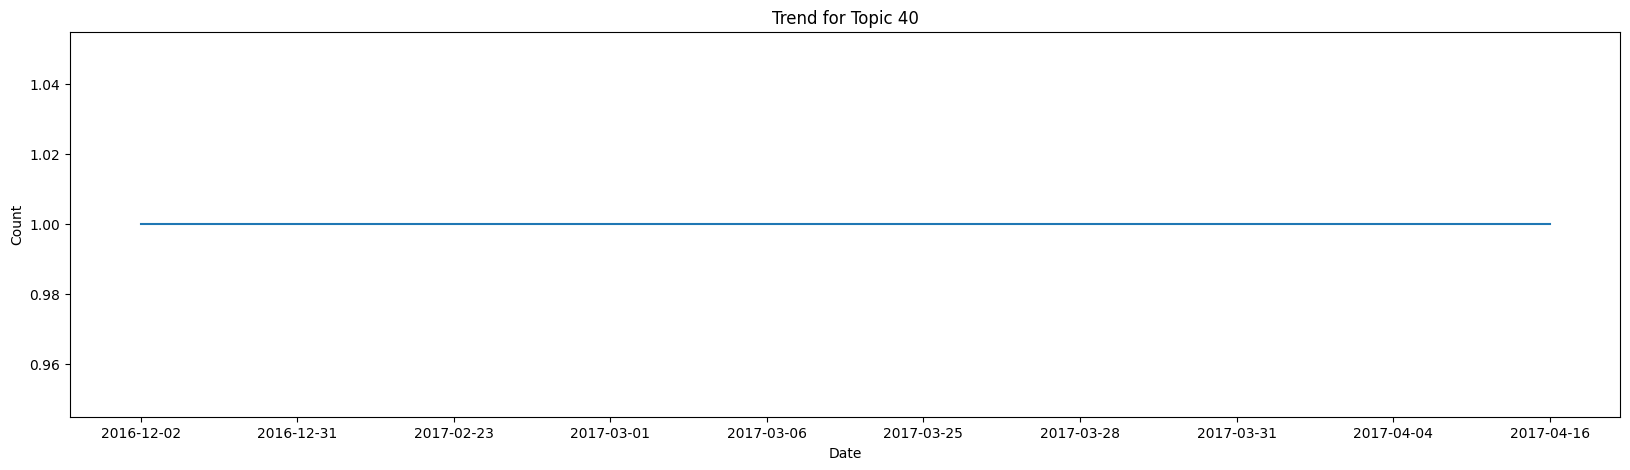

In [ ]:

topic_time_distribution = df.groupby(['date', 'topic']).size().reset_index(name='count')
specific_topic = 40
specific_topic_data = topic_time_distribution[topic_time_distribution['topic'] == specific_topic]
plt.figure(figsize=(20, 5))
sns.lineplot(data=specific_topic_data, x='date', y='count')
plt.title(f"Trend for Topic {specific_topic}")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()



In [13]:
names

0                     -1_new_know_watch_says
1                0_trump_donald_trumps_obama
2                  1_nfl_super_patriots_bowl
3                 2_nba_warriors_game_lebron
4          3_basketball_ncaa_tournament_bowl
5                 4_day_patricks_2017_easter
6                 5_barcelona_madrid_real_fc
7                     6_dies_dead_death_star
8              7_globes_golden_awards_oscars
9              8_trailer_movie_batman_marvel
10           9_tour_album_kendrick_announces
11         10_victorias_secret_topless_bella
12     11_arrested_prison_released_hernandez
13          12_pregnant_child_expecting_baby
14          13_foot_federer_roger_australian
15                 14_musk_elon_stock_rocket
16            15_police_shooting_killed_shot
17                           16_la_que_se_el
18             17_mlb_opening_phillies_tebow
19           18_recap_premiere_finale_season
20               19_bruins_nhl_game_penguins
21               20_ufc_fight_conor_decision
22        

In [10]:
topic_model.get_topic(11)

[('arrested', 0.13510801464522987),
 ('prison', 0.08373711507809678),
 ('released', 0.07624185566278797),
 ('hernandez', 0.06694835507784773),
 ('charges', 0.05743286884364383),
 ('jail', 0.05318693201979771),
 ('gates', 0.05318693201979771),
 ('aaron', 0.05082790377519198),
 ('black', 0.0480262878519264),
 ('rape', 0.047907834517318004)]

In [11]:
topic_model.visualize_topics()